# Guide to Extracting Data w/ APIs from the Withings ScanWatch

<img src="https://imgur.com/3Z2W8HK.png" width="500"/>

Ever wanted a smart watch with an EKG? Introducing the [Withings ScanWatch](https://www.withings.com/us/en/scanwatch), a smart watch that can not only detect your heart rate optically, but also with an EKG! While this notebook is meant for the ScanWatch, it can be easily adapted to any other Withings product with some modifications.

Also note that you need to set up your Withings ScanWatch prior to running this notebook.

If you want to know more about Withings Body+ Scale, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/withings-scanwatch) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

We will be able to extract the following parameters (see the definitions at [this documentation page](https://developer.withings.com/api-reference#operation/sleepv2-getsummary)):

<details>

<summary> <strong> <font size=3> Click here to view all extractable parameters </font> </strong> </summary>

| Parameter Name        | Sampling Frequency |
|-----------------------|--------------------|
| Heart Rate            | Every 10 minutes OR every second (when set to [continuous heart rate mode](https://support.withings.com/hc/en-us/articles/360010042798-ScanWatch-Tracking-my-heart-rate))  |
| # of REM sleep phases | Per sleep          |
| Sleep Efficiency      | Per sleep          |
| Sleep Latency         | Per sleep          |
| Total Sleep Time      | Per sleep          |
| Total Time in bed     | Per sleep          |
| Wakeup latency        | Per sleep          |
| Waso                  | Per sleep          |
| Asleepduration        | Per sleep          |
| Deep sleep duration   | Per sleep          |
| Duration to sleep     | Per sleep          |
| Duration to wakeup    | Per sleep          |
| Average heart rate    | Per sleep          |
| Max heart rate        | Per sleep          |
| Min heart rate        | Per sleep          |
| Light sleep duration  | Per sleep          |
| Night events          | Per sleep          |
| Out of bed count      | Per sleep          |
| REM sleep duration    | Per sleep          |
| Average resp rate    | Per sleep          |
| Minimal resp. rate    | Per sleep          |
| Max resp. rate        | Per sleep          |
| Sleep score           | Per sleep          |
| Total snoring time    | Per sleep          |
| Snoring episode count | Per sleep          |
| Wakeup count          | Per sleep          |
| Wakeup duration       | Per sleep          |


</details>

Note that Withings provides even more measurements than just these. You can check these out at the [API reference](https://developer.withings.com/api-reference/). Since we focus on heart rate and sleep here, though, those are the main measurement types we extract.

<br><br>
In this guide, we sequentially cover the following **nine** topics to extract from the Withings API:
1. **Setup**
    - We cover setting up the watch and library imports in this section.
2. **Authentication/Authorization** 
    - This requires a couple extra steps on your part using OAuth and a 2-step verification process through `wearipedia`.
3. **Data extraction**
    - We can get data via our `wearipedia` package
    - Due to our own limited sample size, which precludes long time horizon data analysis, we include a data extraction step that loads an artificial dataset we randomly generate.
    
4. **Data exporting** 
    - We export the data via Pandas DataFrame into file formats compatible by R, Excel, and Matlab.
5. **Adherence** 
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Data visualization**
    - 6.1: We reproduce a plot for heart rate over the course of a day
    - 6.2: We reproduce a plot for sleep data over the course of a week
    - 6.3: We visualize the times / days when the user fails to wear the watch.
7. **Advance Visualization** 
    - We plot a calendar heatmap of watch wear time every day, revealing which days the user has worn the watch most.
    - We also look at how sleep duration varies over different weekdays and months for longer data timeframes.
8. **Outlier Detection and Data Cleaning** 
    - We demonstrate a simple outlier detection algorithm running on the dataset and clean the outliers out completely
5. **Data analysis**
    - 9.1: We try to find a correlation between the length of a sleep period and the median heart rate for that sleep period. We find that the correlation is not statistically significant.

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own credentials on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Study participant setup and usage


Dear Participant,

Thank you for using this notebook! To set up the watch itself so that you can run this notebook, download the Health Mate app and follow the instructions on the app. The app will pair via bluetooth to the watch. In our experience, this process was fairly straightforward.

Best,

Wearipedia
## 1.2 Wearipedia Library Install
Relevant libraries are imported below. Just run the code to import all the libraries including our unique device data extractor, Wearipedia.

In [1]:
#@title Library import + setup

# sneak in the library imports etc. here :)

# upgrade scipy, since we need "intercept_stderr"
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
!pip install --upgrade scipy -q
!pip install wearipedia
!pip install july -q # for calendar plotting

import json
from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy import stats
import july
from july.utils import date_range

from datetime import timedelta, datetime
import pandas as pd
import numpy as np

# suppresses unnecessary warning
pd.options.mode.chained_assignment = None


# import wearipedia and get instance of device
import wearipedia
device = wearipedia.get_device('withings/scanwatch')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 2.0 MB/s eta 0:00:00
  Created wheel for garminconnect: filename=garminconnect-0.1.54-py3-none-any.whl size=13614 sha256=92e5be9b7ce1e835831defdb2b4e6ba33406473df5425b70c5928dc1fe2fdfb6
  Stored in directory: /root/.cache/pip/wheels/d9/3b/2a/0a0197cc2be72da01e358dc415929a0fc322de18c96c58b68d
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=91725d55edbd32712134b46d11b705a6f7636971ae1631af140e65250a082373
  S

# 2. Authentication/Authorization

To be able to make requests to the API, the easiest way is to use the public developer API. This section roughly follows the steps outlined [here](https://developer.dexcom.com/authentication) on their website.

First, follow the non-colab steps listed below:

1. Visit the [developer portal](https://developer.withings.com/) and click "Open Developer Dashboard" on the top right.
2. Once logged in, click "Add an app".
3. For now, you can just click "I don't know" under "Services", accept terms of use, and click "Next".
5. Put whatever you want under "Application Name" (we used `withings-test`), anything under "Application Description", and "https://wbsapi.withings.net/v2/oauth2" under Registered URLs, then click "Done".
    - NOTE: "registered URLs" is intended to be a URL to a webserver you control and can receive requests from. However, in this notebook we are simply using it as a placeholder, as this functionality is not strictly necessary for obtaining your data.

In the end, you should see something like the below.

<img src="https://i.imgur.com/ttWojjU.png"></img>

Now we can proceed with the rest of the notebook.

To be able to make requests to the API and extract the data we need, we need to first issue an access token. This (ephemeral) access token will serve as our key to the data. While, you don't necessarily need to be familiar with how the issuing of the authtoken occurs, you can learn more about it by visiting [the official Withings tutorial](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/get-access/oauth-web-flow/).

In [2]:
#@title 5. Enter your credentials below (from the application you just created) or click synthetic if you do not want real data
CLIENT_ID = "" #@param {type:"string"}
CUSTOMER_SECRET = "" #@param {type:"string"}
use_synthetic = True #@param {type:"boolean"}
credentials = {"client_id": CLIENT_ID, "client_secret": CUSTOMER_SECRET}
if not use_synthetic:
  device.authenticate(credentials)

6. Now visit the above URL and click "Allow this app", and copy the URL you were redirected to into the text field below. Note that if you mess up once, you have to go through the above URL again (including clicking "Allow this app"). Also, the URL is only valid for 30 seconds, so be quick in pasting to the output field!

Now that we have our access token, we can begin making requests to the API! This access token will last only three hours, though, so you would need to re-do step 6 if three hours pass.

# 3. Data extraction

Here, data extraction is pretty simple! 

Data can be extracted via wearipedia, our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

Please go back to step 5 of Authentication/Authorization where you can uncheck the "use_synthetic" box to instead use your own *real* data via Withings API calls! See [the overall health data API page](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/data-api/all-available-health-data) or the ["Measure" endpoints specifically](https://developer.withings.com/api-reference/#operation/measurev2-getactivity) for more info.

In [12]:
#@title Extract data via the API!
#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2020-01-01' #@param {type:"date"}
end_date='2022-12-01' #@param {type:"date"}
params = {"start": start_date, "end": end_date}

hr_df = device.get_data("heart_rates", params=params) 
sleeps_df = device.get_data("sleeps", params=params) 


In [13]:
hr_df

,datetime,heart_rate,model,model_id,deviceid
0,2022-01-28 05:35:34,90,None,1059,None
1,2021-12-04 18:42:32,82,None,1059,None
2,2022-02-16 19:43:07,92,None,1059,None
3,2022-02-11 11:49:30,94,None,1059,None
4,2021-11-23 17:46:28,79,None,1059,None
...,...,...,...,...,...
15478,2022-06-16 23:00:00,93,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
15479,2022-06-16 23:10:00,89,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
15480,2022-06-16 23:20:00,91,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
15481,2022-06-16 23:30:00,87,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e


In [14]:
sleeps_df

,id,timezone,model,model_id,hash_deviceid,date,startdate,enddate,data,created,modified
0,75434668,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-03-01,1646190000,1646211600,"{'wakeupduration': 1915, 'wakeupcount': 1, 'du...",1646211600,1646211600
1,2215104,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-03-02,1646283600,1646308800,"{'wakeupduration': 1308, 'wakeupcount': 0, 'du...",1646308800,1646308800
2,38712131,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-03-03,1646370000,1646395200,"{'wakeupduration': 1306, 'wakeupcount': 0, 'du...",1646395200,1646395200
3,60969723,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-03-04,1646456400,1646474400,"{'wakeupduration': 449, 'wakeupcount': 1, 'dur...",1646474400,1646474400
4,58554051,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-03-05,1646542800,1646568000,"{'wakeupduration': 1672, 'wakeupcount': 3, 'du...",1646568000,1646568000
...,...,...,...,...,...,...,...,...,...,...,...
102,13715843,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-06-11,1655002800,1655017200,"{'wakeupduration': 2341, 'wakeupcount': 2, 'du...",1655017200,1655017200
103,41336362,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-06-12,1655096400,1655125200,"{'wakeupduration': 1925, 'wakeupcount': 2, 'du...",1655125200,1655125200
104,34407373,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-06-13,1655197200,1655211600,"{'wakeupduration': 1025, 'wakeupcount': 2, 'du...",1655211600,1655211600
105,47654887,America/Los_Angeles,16,93,d41d8cd98f00b204e9800998ecf8427e,2022-06-14,1655276400,1655301600,"{'wakeupduration': 2321, 'wakeupcount': 1, 'du...",1655301600,1655301600


Now that we've got dataframes with data, we can see the data they have. In particular, we have a ton of measurements from a non-ScanWatch device, so we'll get rid of those. Note that it is theoretically possible to have another ScanWatch device (and maybe the model name will be `ScanWatch2`, or something different), but we were unable to test this, so if you switch between devices you might want to be careful here.

In [15]:
hr_df = hr_df.drop(np.where(hr_df.model != 'ScanWatch')[0])
hr_df

,datetime,heart_rate,model,model_id,deviceid
1000,2022-03-01 00:00:00,84,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1001,2022-03-01 00:10:00,92,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1002,2022-03-01 00:20:00,91,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1003,2022-03-01 00:30:00,86,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
1004,2022-03-01 00:40:00,87,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
...,...,...,...,...,...
15478,2022-06-16 23:00:00,93,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
15479,2022-06-16 23:10:00,89,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
15480,2022-06-16 23:20:00,91,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e
15481,2022-06-16 23:30:00,87,ScanWatch,93,d41d8cd98f00b204e9800998ecf8427e


And now we have eliminated irrelevant rows!

# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.), CSV, and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to all these formats is fairly simple since we return a Pandas DataFrame. We export each datatype separately (JSON only) and also export a complete version that includes all simultaneously.

In [ ]:
#@title Select which format to export data!
# set which format you prefer to export
use_JSON = True #@param {type:"boolean"}
use_CSV = True #@param {type:"boolean"}
use_Excel = True #@param {type:"boolean"}

if use_JSON:
  for column in hr_df.columns:
    column_list = hr_df[column].tolist()

    # If the first column contains Timestamp objects, convert to strings
    if isinstance(column_list[0], pd.Timestamp):
        column_list = [x.strftime("%Y-%m-%d %H:%M:%S") for x in column_list]

    # Write the list to a JSON file with its corresponding type as the title
    filename = "hr_" + column + ".json"
    with open(filename, 'w') as f:
        json.dump(column_list, f)
  for column in sleeps_df.columns:
    column_list = sleeps_df[column].tolist()

    # If the first column contains Timestamp objects, convert to strings
    if isinstance(column_list[5], pd.Timestamp):
        column_list = [x.strftime("%Y-%m-%d %H:%M:%S") for x in column_list]

    # Write the list to a JSON file with its corresponding type as the title
    filename = "sleeps_" + column + ".json"
    with open(filename, 'w') as f:
        json.dump(column_list, f)

  # Convert both dfs to dictionary and make sure TimeStamps are strings
  heart_df_JSON = hr_df
  heart_df_JSON.loc[:, 'datetime'] = heart_df_JSON['datetime'].apply(lambda x: str(x))
  heart_df_JSON = heart_df_JSON.to_dict(orient='records')
  sleep_df_JSON = sleeps_df
  sleep_df_JSON = sleep_df_JSON.to_dict(orient='records')

  # Write both dictionaries to a JSON file
  with open('hr_data.json', 'w') as outfile:
      json.dump(heart_df_JSON, outfile)
  with open('sleeps_data.json', 'w') as outfile:
      json.dump(sleep_df_JSON, outfile)
if use_CSV:
  # Write both the dataframes to a CSV file
  hr_df.to_csv("hr.csv", index=False)
  sleeps_df.to_csv("sleeps.csv", index=False)
if use_Excel:
  # Write both the dataframes to an Excel file
  hr_df.to_excel("hr.xlsx", index=False)
  sleeps_df.to_excel("sleeps.xlsx", index=False)

Feel free to open the file viewer (see left pane) to look at the outputs!


# 5. Adherence
In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant had the watch on and off throughout the entirety of the time period, allowing you to calculate measurement consistency, etc. We designate separate adherences for heart rate and sleep as the ser can have varying usage for sleep vs. wearing it in the daytime for heart rate measurements.

We will first delete a certain % of blocks either at the day level or week level, with user input. However, you can also select whether you want to only detect adherence by selecting the detect adherence only option for real data.

In [16]:
#@title Non-adherence simulation and detection
import random as random
block_level = "day" #@param ["day", "week"]
hr_nonadherence_percent = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
sleep_nonadherence_percent = 0.26 #@param {type:"slider", min:0, max:1, step:0.01}
detect_adherence_only = False #@param {type:"boolean"}

def remove_dates(dates, percent, by_week):
    """
    Removes a percentage of dates by week or day.
    
    :param dates: list of datetime objects representing the dates to be processed
    :param percent: float representing the percentage of dates to be removed
    :param by_week: string indicating whether to remove dates by week (True) or by day (False)
    :return: list of datetime objects representing the remaining dates after removal
    """
    # Sort the dates in ascending order
    dates_sorted = sorted(dates)

    # Define the step size for removal based on the by_week parameter
    step_size = 7 if by_week == "week" else 1
    len_dates_sorted = len(dates_sorted)
    
    # Calculate the number of dates to be removed based on the percentage
    num_dates_to_remove = int(int(len_dates_sorted / step_size) * percent)
    
    list_indices = []
    while num_dates_to_remove > 0:
      random_index = random.randint(0, len_dates_sorted)
      for i in range(random_index, random_index + step_size):
        list_indices.append(i)
      num_dates_to_remove-=1

    # create a new list that excludes the elements at the specified indices
    new_dates_sorted = [date for i, date in enumerate(dates_sorted) if i not in list_indices]
    # Return the remaining dates
    return new_dates_sorted

hrs_adherence = hr_df
hrs_adherence['datetime'] = pd.to_datetime(hrs_adherence['datetime'], format='%Y-%m-%d %H:%M:%S')
sleep_adherence = sleeps_df

if not detect_adherence_only:
  if block_level == "day":
      block_length = 1
  elif block_level == "week":
      block_length = 7

  hr_unique_dates = hrs_adherence['datetime'].dt.date.unique()
  hr_num_blocks_to_keep = remove_dates(hr_unique_dates, hr_nonadherence_percent, block_level)
  sleep_num_blocks = len(sleeps_df['date'].tolist()) # length of entries in DF using the date column
  sleep_num_blocks_to_keep = int(sleep_nonadherence_percent * sleep_num_blocks)
  print(hr_num_blocks_to_keep)

  hrs_adherence = hrs_adherence.reset_index(drop=True) # reset the index
  hr_date_mask = hrs_adherence['datetime'].dt.date.isin(hr_num_blocks_to_keep)
  sleep_adherence = sleep_adherence.reset_index(drop=True) # reset the index
  sleep_idxes = np.random.choice(np.arange(sleep_num_blocks), replace=False, size=sleep_num_blocks_to_keep)
  hr_rows_to_remove = hrs_adherence[hr_date_mask].index
  hrs_adherence = hrs_adherence.drop(hr_rows_to_remove)
  sleep_adherence = sleep_adherence.drop(sleep_idxes.tolist())
  

[datetime.date(2022, 3, 2), datetime.date(2022, 3, 3), datetime.date(2022, 3, 4), datetime.date(2022, 3, 7), datetime.date(2022, 3, 8), datetime.date(2022, 3, 10), datetime.date(2022, 3, 12), datetime.date(2022, 3, 13), datetime.date(2022, 3, 14), datetime.date(2022, 3, 15), datetime.date(2022, 3, 16), datetime.date(2022, 3, 19), datetime.date(2022, 3, 20), datetime.date(2022, 3, 23), datetime.date(2022, 3, 24), datetime.date(2022, 3, 26), datetime.date(2022, 3, 27), datetime.date(2022, 3, 28), datetime.date(2022, 3, 30), datetime.date(2022, 4, 1), datetime.date(2022, 4, 2), datetime.date(2022, 4, 4), datetime.date(2022, 4, 7), datetime.date(2022, 4, 8), datetime.date(2022, 4, 10), datetime.date(2022, 4, 11), datetime.date(2022, 4, 13), datetime.date(2022, 4, 14), datetime.date(2022, 4, 16), datetime.date(2022, 4, 17), datetime.date(2022, 4, 20), datetime.date(2022, 4, 22), datetime.date(2022, 4, 24), datetime.date(2022, 4, 25), datetime.date(2022, 4, 26), datetime.date(2022, 4, 28), d

And now we simulated having significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time. 

Now let's detect non-adherence. We will return a Pandas DataFrame sampled everyday for sleep and every 10 minutes for heart rate.

In [17]:
hr_start_date = hr_df.iloc[0]['datetime']
hr_end_date = hr_df.iloc[-1]['datetime']

sleep_start_date = sleeps_df.iloc[0]['date']
sleep_end_date = sleeps_df.iloc[-1]['date']

hr_ts_col = pd.date_range(hr_start_date, hr_end_date, freq="600s")
sleep_ts_col = pd.date_range(sleep_start_date, sleep_end_date, freq="D", normalize=True)
hr_using_arr = np.zeros(len(hr_ts_col))
sleep_using_arr = np.zeros(len(sleep_ts_col))

for i, dt in enumerate(hrs_adherence['datetime']):
    ts = pd.Timestamp(pd.to_datetime(dt))
    idxes = np.where(hr_ts_col == ts)[0]
    if len(idxes) >= 1:
      hr_using_arr[idxes[0]] = 1

for i, dt in enumerate(sleep_adherence['date']):
    ts = pd.Timestamp(pd.to_datetime(dt))
    idxes = np.where(sleep_ts_col == ts)[0]
    if len(idxes) >= 1:
      sleep_using_arr[idxes[0]] = 1

sleep_adherence_detect = pd.DataFrame()
hr_adherence_detect = pd.DataFrame()
sleep_adherence_detect['timestamp'] = sleep_ts_col
hr_adherence_detect['timestamp'] = hr_ts_col
sleep_adherence_detect['is_using'] = sleep_using_arr.astype('bool')
hr_adherence_detect['is_using'] = hr_using_arr.astype('bool')

We can plot this out, and we get adherence at a daily frequency throughout the entirety of the data collection period.

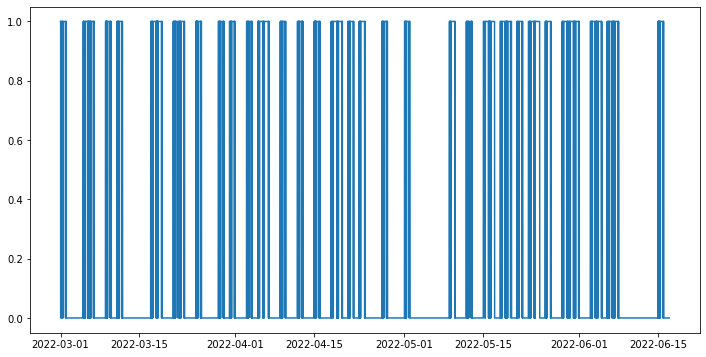

In [18]:
#@title HR Adherence Plot
plt.figure(figsize=(12, 6))
plt.plot(hr_adherence_detect.timestamp, hr_adherence_detect.is_using)


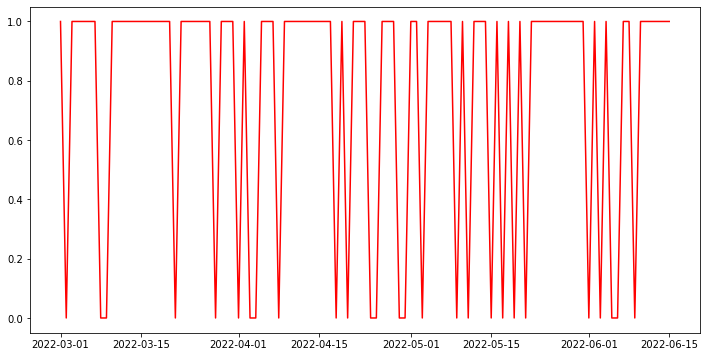

In [ ]:
#@title Sleep Adherence Plot
plt.figure(figsize=(12, 6))
plt.plot(sleep_adherence_detect.timestamp, sleep_adherence_detect.is_using, color='Red')


We can also turn these into a list of start and stop points.

In [19]:
#@title HR Start/Stop Points
from itertools import groupby

def contiguous_regions(a):
    i = 0
    res = []

    for k, g in groupby(a):
        l = len(list(g))
        if k:
            res.append((i,i+l))
        i += l

    return res

start_stops = []
for x in contiguous_regions(hr_adherence_detect.is_using):
    if x[0] >= 0 and x[0] < len(hr_adherence_detect) and x[1] >= 0 and x[1] < len(hr_adherence_detect):
        start_stops.append((hr_adherence_detect.timestamp[x[0]], hr_adherence_detect.timestamp[x[1]]))
start_stops

[(Timestamp('2022-03-01 00:00:00'), Timestamp('2022-03-01 00:50:00')),
 (Timestamp('2022-03-01 01:00:00'), Timestamp('2022-03-01 04:00:00')),
 (Timestamp('2022-03-01 04:10:00'), Timestamp('2022-03-01 08:40:00')),
 (Timestamp('2022-03-01 08:50:00'), Timestamp('2022-03-01 09:40:00')),
 (Timestamp('2022-03-01 09:50:00'), Timestamp('2022-03-01 21:30:00')),
 (Timestamp('2022-03-01 21:40:00'), Timestamp('2022-03-01 23:50:00')),
 (Timestamp('2022-03-05 00:20:00'), Timestamp('2022-03-05 02:10:00')),
 (Timestamp('2022-03-05 02:20:00'), Timestamp('2022-03-05 03:20:00')),
 (Timestamp('2022-03-05 03:30:00'), Timestamp('2022-03-05 04:10:00')),
 (Timestamp('2022-03-05 04:20:00'), Timestamp('2022-03-05 08:30:00')),
 (Timestamp('2022-03-05 08:40:00'), Timestamp('2022-03-05 09:50:00')),
 (Timestamp('2022-03-05 10:00:00'), Timestamp('2022-03-05 20:00:00')),
 (Timestamp('2022-03-05 20:10:00'), Timestamp('2022-03-05 20:30:00')),
 (Timestamp('2022-03-05 20:40:00'), Timestamp('2022-03-05 21:40:00')),
 (Time

In [ ]:
#@title Sleep Start/Stop Points
from itertools import groupby

def contiguous_regions(a):
    i = 0
    res = []

    for k, g in groupby(a):
        l = len(list(g))
        if k:
            res.append((i,i+l))
        i += l

    return res

start_stops = []
for x in contiguous_regions(sleep_adherence_detect.is_using):
    if x[0] >= 0 and x[0] < len(sleep_adherence_detect) and x[1] >= 0 and x[1] < len(sleep_adherence_detect):
        start_stops.append((sleep_adherence_detect.timestamp[x[0]], sleep_adherence_detect.timestamp[x[1]]))
start_stops

[(Timestamp('2022-03-01 00:00:00'), Timestamp('2022-03-02 00:00:00')),
 (Timestamp('2022-03-03 00:00:00'), Timestamp('2022-03-08 00:00:00')),
 (Timestamp('2022-03-10 00:00:00'), Timestamp('2022-03-21 00:00:00')),
 (Timestamp('2022-03-22 00:00:00'), Timestamp('2022-03-28 00:00:00')),
 (Timestamp('2022-03-29 00:00:00'), Timestamp('2022-04-01 00:00:00')),
 (Timestamp('2022-04-02 00:00:00'), Timestamp('2022-04-03 00:00:00')),
 (Timestamp('2022-04-05 00:00:00'), Timestamp('2022-04-08 00:00:00')),
 (Timestamp('2022-04-09 00:00:00'), Timestamp('2022-04-18 00:00:00')),
 (Timestamp('2022-04-19 00:00:00'), Timestamp('2022-04-20 00:00:00')),
 (Timestamp('2022-04-21 00:00:00'), Timestamp('2022-04-24 00:00:00')),
 (Timestamp('2022-04-26 00:00:00'), Timestamp('2022-04-29 00:00:00')),
 (Timestamp('2022-05-01 00:00:00'), Timestamp('2022-05-03 00:00:00')),
 (Timestamp('2022-05-04 00:00:00'), Timestamp('2022-05-09 00:00:00')),
 (Timestamp('2022-05-10 00:00:00'), Timestamp('2022-05-11 00:00:00')),
 (Time



```
# This is formatted as code
```

## 6. Visualization

In this section, you'll expect to see a couple plots from the Health Mate mobile app reproduced.

# 6.1: Heart rate single day
First, we'll reproduce the below plot you can find in the Health Mate mobile app that displays heart rate data over the course of a single day. This plot is super helpful because it allows you to view the heart rate signal at a very granular level, and see how it varies over the course of a few hours.

<img src="https://imgur.com/w7Z9G9X.png"></img>

*Above is a plot taken from the official Withings mobile app.*

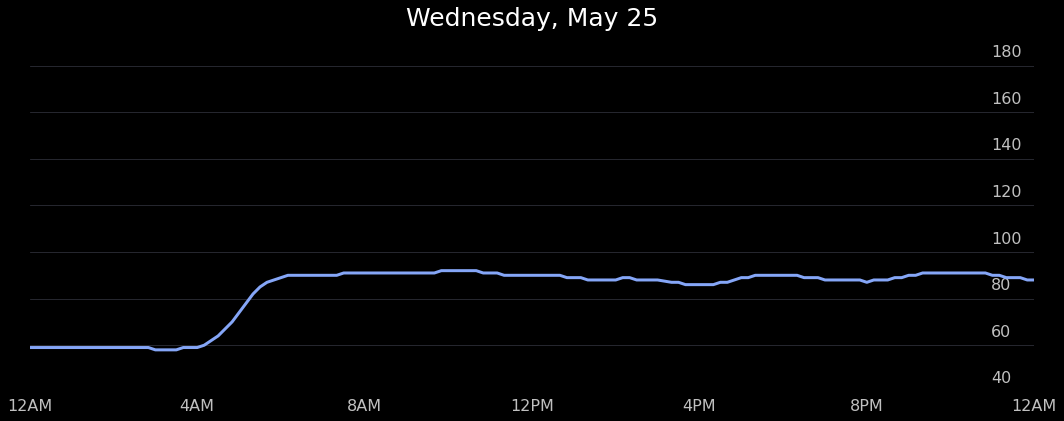

In [ ]:
#@title Enter date
date = "2022-05-25" #@param {type:"date"}
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
import matplotlib.transforms

from dateutil import tz
from scipy.interpolate import make_interp_spline
from datetime import timedelta

# measurements are taken every 10 minutes, displayed on app every 30
HEART_RATE_RECORDING_LENGTH = 30 * 60

with plt.style.context('dark_background'):
    # get the start and end times as timestamps by using the datetime library
    start_ts = datetime.strptime(date + ' 00:00:00-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()
    #end_ts = datetime.strptime(date + ' 23:59:59-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()
    end_ts = start_ts + 24 * 3600 + 30 * 60  # 00:30 the next day
    #end_ts = datetime.strptime('2022-05-25 00:30:00-07:00', '%Y-%m-%d %H:%M:%S%z').timestamp()

    # now find the indices in hr_df.timestamp that match as closely as possible
    start_idx = np.argmin(np.abs(hr_df.datetime.apply(lambda x: x.timestamp()) - start_ts))
    end_idx = np.argmin(np.abs(hr_df.datetime.apply(lambda x: x.timestamp()) - end_ts))

    x = hr_df.datetime.iloc[start_idx:end_idx]
    y = hr_df.heart_rate.iloc[start_idx:end_idx]

    # make it not as bumpy with gaussian filter. note that this does not reproduce
    # the curve exactly, as I'm not sure what smoothing algorithm they used...
    y = gaussian_filter(y, sigma=3)

    fig = plt.figure(figsize=(18,6), facecolor='black')

    x_timestamp = np.array([x_.timestamp() for x_ in x])

    # get the gaps. we include [6] as well because when you do np.diff,
    # it actually leaves out exactly one element
    differences = np.concatenate((np.diff(x_timestamp), [60 * 10]))

    # interpret a gap (i.e. when a user takes off the device for some prolonged
    # period of time) as any two measurements that are taken more than
    # 6 * 2 = 12 seconds apart, to account for minor variations around 6s
    gap_idxes = np.where(differences > HEART_RATE_RECORDING_LENGTH * 2)[0]

    # get the sleeps
    sleep_idxes = []
    for lower, upper in zip(sleeps_df.startdate, sleeps_df.enddate):
        if lower < start_ts or upper > end_ts:
            continue
        # get the location in the timestamp array that is closest to `lower`
        lower_idx = np.argmin(np.abs((x_timestamp - lower) - 0))
        # get the location in the timestamp array that is closest to `upper`
        upper_idx = np.argmin(np.abs((x_timestamp - upper) - 0))

        sleep_idxes.append((lower_idx, upper_idx))

    # first, we just plot the entire thing
    plt.plot(x, y, linewidth=3, color='#85a6f7')

    # now we overlay sleeps
    for sleep_start, sleep_end in sleep_idxes:
        plt.plot(x[sleep_start:sleep_end], y[sleep_start:sleep_end], linewidth=3, color='#3E414C')

        plt.axvline(x=x.iloc[sleep_start], linestyle='--', linewidth=1.5, color='#2F303A')

        plt.axvline(x=x.iloc[sleep_end], linestyle='--', linewidth=1.5, color='#2F303A')

    # now we overlay gaps by overlaying with white
    for gap_idx in gap_idxes:
        plt.plot(x[gap_idx:gap_idx+2], y[gap_idx:gap_idx+2], linewidth=5, color='black')

    plt.ylim(40, 180)
    plt.xlim(x.iloc[0], x.iloc[-1] - pd.Timedelta(minutes=30))

    datetimes = [
        datetime.strptime(date + ' 00:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 04:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 08:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 12:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 16:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 20:00:00-0700', '%Y-%m-%d %H:%M:%S%z'),
        datetime.strptime(date + ' 00:00:00-0700', '%Y-%m-%d %H:%M:%S%z') + timedelta(days=1)
    ]

    plt.xticks(ticks=datetimes, labels=['12AM', '4AM', '8AM', '12PM', '4PM', '8PM', '12AM'])

    # get the y-axis ticks to appear on the right
    plt.gca().yaxis.tick_right()

    #plt.gca().grid(axis='x', color='#2F303A')
    plt.gca().grid(axis='y', color='#2F303A', which='major')

    # hide x-axis and make the xtick labels 16 size
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # hide y-axis and make the ytick labels 16 size
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        right=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # add offset to y-axis tick labels to make them appear above gridlines
    # instead of to the side
    # https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
    dx = -50/72.; dy = 15/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in plt.gca().yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)


    title_text = datetime.strftime(datetime.strptime(date, '%Y-%m-%d'), '%A, %B %d')

    plt.title(title_text, fontsize=25, pad=40)

    # turn off all borders
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

*Above is a plot we created ourselves!*

Cool! Feel free to switch up the dates in the form as well, and see the user's heart rate for any day data has been collected for!

## 6.2: Sleeps over the course of a week

Now let's try to reproduce the plot below, which shows when and how long the user sleeps every day of the week. This is super cool because we can look at the user's sleeping patterns for an entire week at a glance, instead of having to sift through rows in a dataframe! We can do this by poking deeper into the [Matplotlib architecture](https://www.aosabook.org/en/matplotlib.html) into the Artist layer and directly adding rounded rectangles to the plot.

<img src="https://imgur.com/tV3K4wB.png"></img>

*The above plot is taken directly from the mobile app.*

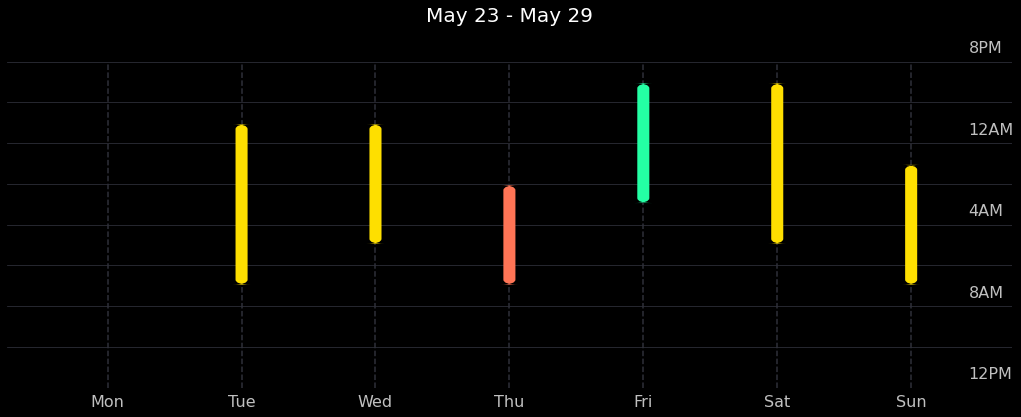

In [ ]:
#@title Insert start of week (must be a Monday) and timezone name

week_start = "2022-05-23" #@param {type:"date"}
timezone_name = "America/Los_Angeles" #@param {type:"string"}

from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
import matplotlib.transforms
import matplotlib.patches as patches
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from dateutil import tz
from scipy.interpolate import make_interp_spline

from datetime import timezone
import pytz

def timestamp_to_hour_min(timestamp, tz_name='America/Los_Angeles'):
    # convert timezone to '%H:%M' in local timezone

    local_tz = pytz.timezone(tz_name)
    return datetime.fromtimestamp(int(timestamp)).replace(tzinfo=timezone.utc).astimezone(local_tz).strftime('%H:%M')

def hour_min_to_vert_pos(hour_min):
    num_mins = (int(hour_min.split(':')[0]) * 60 + int(hour_min.split(':')[1]))
    vert_dist = (16 * 60 - num_mins) / (16 * 60)

    return vert_dist

# measurements are taken every 10 minutes, displayed on app every 30
HEART_RATE_RECORDING_LENGTH = 30 * 60

NUM_DAYS = 7
RECT_WIDTH = 0.02
RECTS_START = 0.1
RECTS_END = 0.9

# add on timezone
timezone_offset = datetime.now(pytz.timezone(timezone_name)).strftime('%z')
week_start = week_start + timezone_offset
week_start_ts = datetime.strptime(week_start, '%Y-%m-%d%z').timestamp()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(18,6), facecolor='black')

    for day_num in range(NUM_DAYS):
        rect_center_pos = RECTS_START + day_num / (NUM_DAYS-1) * (RECTS_END - RECTS_START)
        # zorder to ensure it is drawn behind rect
        plt.axvline(x=rect_center_pos, linestyle='--', linewidth=1.5, color='#2F303A', zorder=0)

        # rounded rectangles
        # https://stackoverflow.com/questions/58425392/bar-chart-with-rounded-corners-in-matplotlib

        # subtract 4 hours because we want to capture sleeps that start from 8pm
        # and onward
        day_ts = week_start_ts + day_num * 24 * 3600 - 4 * 3600

        row = sleeps_df[np.logical_and(sleeps_df.startdate >= day_ts, sleeps_df.enddate <= day_ts + 24 * 3600)]

        # get the one with the longest sleep, this is how withings does it
        # source: https://support.withings.com/hc/en-us/community/posts/360026177173-Naps-don-t-count-for-sleep-tracking
        try:
            row = row.iloc[np.argmax(row.enddate - row.startdate)]
        except ValueError:
            continue

        # do a shift by 4 hours to account for difference b/w
        # 8PM and 12AM, a bit of a hack
        row.startdate += 4 * 3600
        row.enddate += 4 * 3600

        start, end = timestamp_to_hour_min(row.startdate, tz_name=timezone_name), timestamp_to_hour_min(row.enddate, tz_name=timezone_name)

        top_pos, bottom_pos = hour_min_to_vert_pos(start), hour_min_to_vert_pos(end)

        if row.data['sleep_score'] < 50:
            color = '#ff7455'
        elif row.data['sleep_score'] < 75:
            color = '#FEDF00'
        else:
            color = '#24ffa4'

        rect = patches.FancyBboxPatch((rect_center_pos - RECT_WIDTH / 2, bottom_pos),
                                      RECT_WIDTH, top_pos - bottom_pos,
                                      boxstyle="round,pad=-0.0040,rounding_size=0.015",
                                      linewidth=3, fc=color, ec='none')

        ax.add_patch(rect)

    plt.xticks(ticks=np.linspace(0.1,0.9,NUM_DAYS), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.yticks(ticks=np.linspace(0, 1, 5), labels=['12PM', '8AM', '4AM', '12AM', '8PM'])

    # get the y-axis ticks to appear on the right
    plt.gca().yaxis.tick_right()

    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(n=2))
    plt.gca().grid(axis='y', color='#2F303A', which='both')

    # hide x-axis and make the xtick labels 16 size
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # hide y-axis and make the ytick labels 16 size
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        right=False,      # ticks along the bottom edge are off
        labelsize=16,
        labelcolor='silver'
    )

    # add offset to y-axis tick labels to make them appear above gridlines
    # instead of to the side
    # https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
    dx = -50/72.; dy = 15/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in plt.gca().yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    start_day_fmted = datetime.strftime(datetime.strptime(week_start, '%Y-%m-%d%z'), '%b %d')
    end_day_fmted = datetime.strftime(datetime.strptime(week_start, '%Y-%m-%d%z') + timedelta(days=6), '%b %d')
    plt.title(f'{start_day_fmted} - {end_day_fmted}', size=20, pad=40)

    plt.gca().set_axisbelow(True)
    # turn off all borders
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

*Above is a plot we created ourselves!*

Looks like we were able to pretty accurately reproduce the same things you can see in the mobile app by querying the public API!

# 7. Advance Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

## 7.1: Watch wear time

Now what if we want to check when the user has worn the watch? For example, which days of the month has the user worn the watch, and of the days the user did not wear the watch all day, how much?

Fortunately, this idea is easy to execute with the use of [`july`](https://github.com/e-hulten/july/), a custom library that allows us to create beautiful calendar plots. Unfortunately, since the watch only samples the heart rate extremely sparsely (roughly every 10 minutes by default to preserve battery life), then it is hard to tell exactly when the watch is on or off. As a reasonable proxy of heart rate coverage throughout a particular day, we opt to count the number of hours in that day that the watch has logged at least 3 heart rate measurements for.

Note that we considered using the absolute number of heart rate measurements in a particular day as a proxy, but this is skewed by exercise periods, where the watch records heart rate at a much much higher sampling rate.

In [ ]:
#@title Specify start and end dates and extract watch usage metrics
start_date = "2022-01-01" #@param {type:"date"}
end_date = "2022-06-01" #@param {type:"date"}

dates = date_range(start_date, end_date)
data = np.zeros((len(dates), 24))

# populate data array
for idx, date in tqdm(list(enumerate(dates))):
    local_tz = pytz.timezone('America/Los_Angeles')

    day_start = pd.Timestamp(date).replace(tzinfo=local_tz)

    for i in range(24):
        hour_start, hour_end = day_start + pd.Timedelta(hours=i), day_start + pd.Timedelta(hours=i+1)

        # check for number of measurements during this time
        bool_arr = np.logical_and(datetime.fromtimestamp(int(hour_start.timestamp())) < hr_df.datetime,
               hr_df.datetime < datetime.fromtimestamp(int(hour_end.timestamp())))

        num_measurements = len(np.where(bool_arr)[0])

        if num_measurements >= 3:
            data[idx, i] = 1


100%|██████████| 152/152 [00:05<00:00, 27.16it/s]


Now we make the calendar plot! The above cell calculated `data`. `data` is a 2D numpy array with axes (day, hour), where the first axis refers to a particular day and the second axis refers to a particular hour of the day. The value for, say `data[130,8]`, is exactly one if the user wore his watch from 8am to 9am on day 130 (which is 130 days after `start_date` as specified above) and otherwise zero.

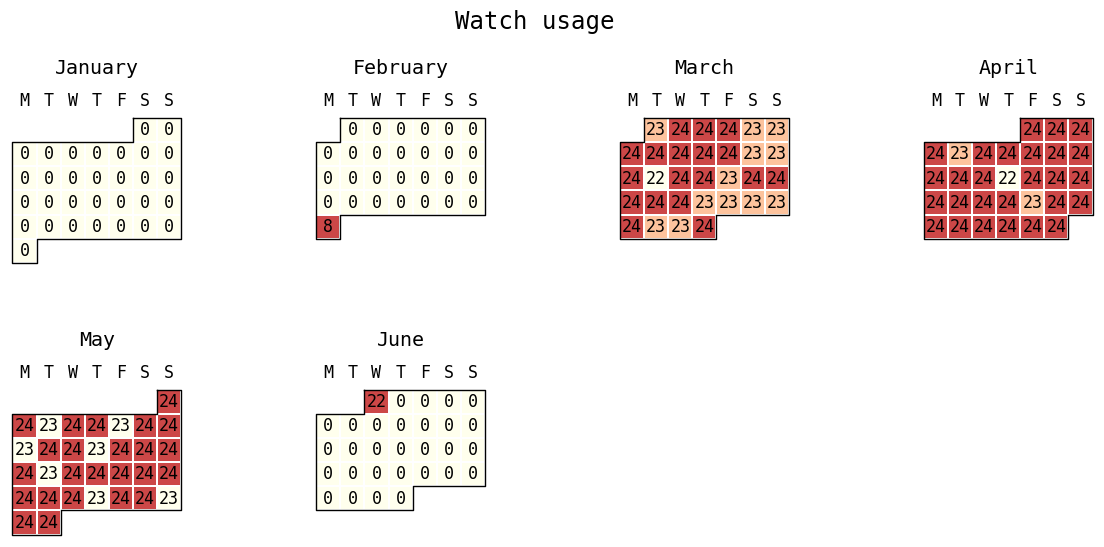

In [ ]:
# sum across hour axis
july.calendar_plot(dates, data.sum(axis=1), value_label=True, weeknum_label=False, title=False)
plt.suptitle('Watch usage', fontsize="x-large", y=1.03)
plt.show()  # suppress output from above line

As we can see, our user has been fairly consistent about wearing his watch during a specific span. He's worn his watch for nearly every hour of the day for that specific span.

If we want to check *when* the user has failed to wear his watch, we can simply look at the `data` array we populated. First, we get the start and end indices for watch measurements.

In [ ]:
start_idx = np.where(data.sum(axis=1) > 0)[0][0]
end_idx = np.where(data.sum(axis=1) > 0)[0][-1]

print(f'Data collection started at index {start_idx}')
print(f'Data collection last performed at index {end_idx}')

Data collection started at index 58
Data collection last performed at index 151


Then, we exclude the first and last indices (because they have gone for half a day, so may skew the data) and look at which hours the user tends to miss for an average day of full usage.

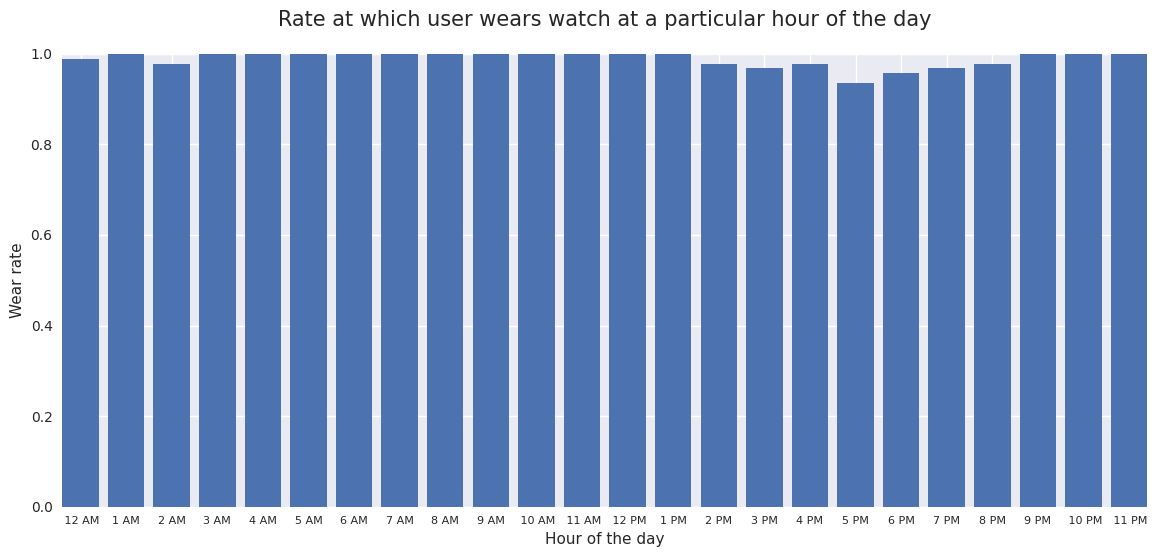

In [ ]:
def stylize_hour_num(hour):
    return datetime.strftime(datetime.strptime(str(hour), '%H'), ' %I %p').replace(' 0','')

with plt.style.context('seaborn'):
    plt.figure(figsize=(14,6))
    plt.bar(np.arange(24), data[start_idx+1:end_idx].mean(axis=0))

    plt.title('Rate at which user wears watch at a particular hour of the day',
              pad=20, fontsize=15)

    plt.xticks(ticks=np.arange(24), labels=[stylize_hour_num(i) for i in range(24)], fontsize=8)

    plt.ylabel('Wear rate')
    plt.xlabel('Hour of the day')

As we can see, though the user sometimes takes his watch off, he still wears it 80% of the time in the worst case.


## 7.2: Sleep Fluctuation by Weekday/Month
Although by default, our app gives us information about the exact sleeptimes that happen in a week and month timeframe, it is definitely necessary to look at how sleep duration varies on different weekdays/months within a longer timeframe. In our example, since we have a short timeframe, the violin plots will mimic the plots from section 6.

Text(0.5, 1.0, 'Sleep Duration by Day of the Week')

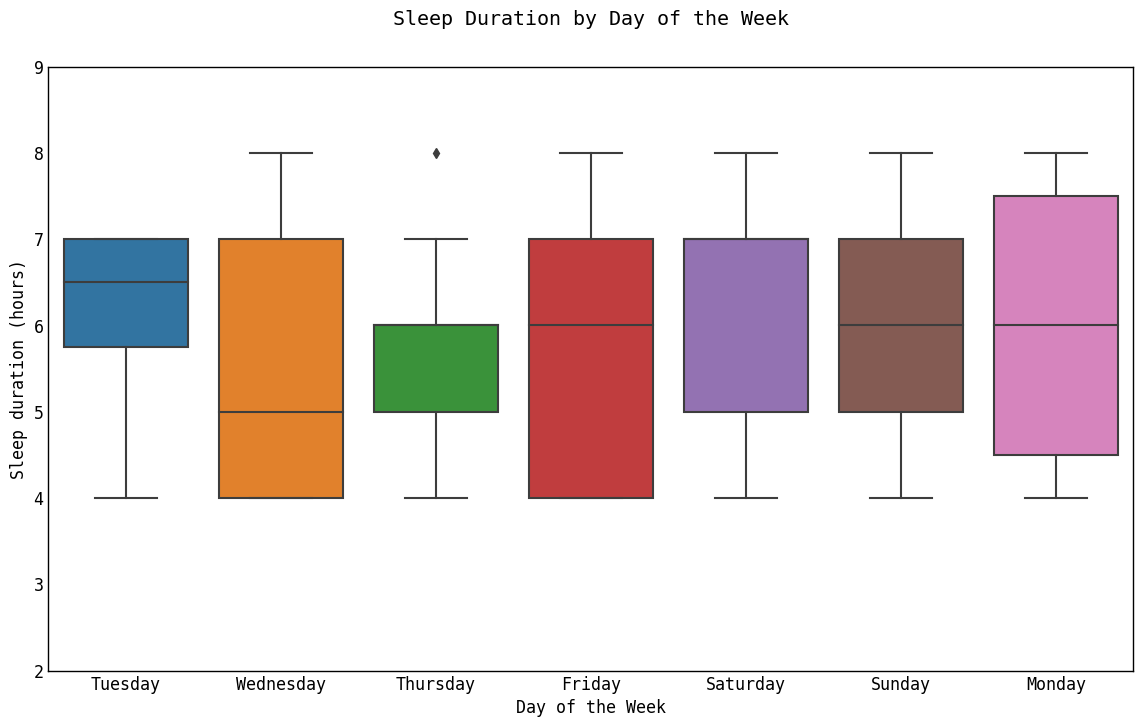

In [ ]:
#@title Plot sleep duration by weekday
sleeps_df['Sleep duration (hours)'] = (sleeps_df['enddate'] - sleeps_df['startdate']) / 3600
sleeps_df['date'] = pd.to_datetime(sleeps_df['date'])
sleeps_df['Day of the Week'] = sleeps_df.date.apply(lambda x: x.strftime('%A'))

plt.figure(figsize=(14,8))
plt.ylim(2, 9)
sns.boxplot(x='Day of the Week', y='Sleep duration (hours)', data=sleeps_df)
plt.title('Sleep Duration by Day of the Week')

Text(0.5, 1.0, 'Sleep Duration by Month')

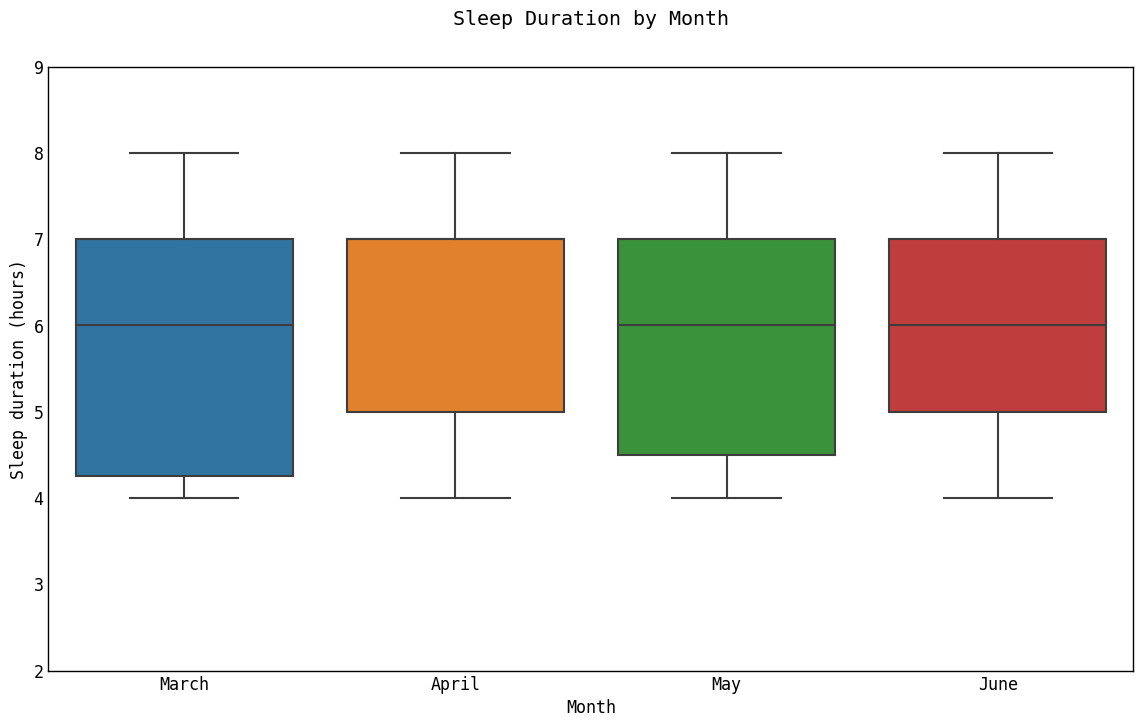

In [ ]:
#@title Plot sleep duration by month
sleeps_df['Month'] = pd.to_datetime(sleeps_df['startdate'], unit='s').dt.month_name()

plt.figure(figsize=(14,8))
plt.ylim(2, 9)
sns.boxplot(x='Month', y='Sleep duration (hours)', data=sleeps_df)
plt.title('Sleep Duration by Month')

# 8: Outlier Detection and Data Cleaning 
In this section, we will perform some data cleaning and detect outliers in our extracted data in order to impute them. Since we want to perform data analysis on our heart rate and sleep, we need to get the daily sleep duration and average our heart rate. 

First, enter in the date range for the data; later on we will normalize out heart rate per sleep session by getting the median heart rate. 


In [ ]:
#@title Set date range and timezone
start = "2020-01-01" #@param {type:"date"}
end = "2022-05-22" #@param {type:"date"}
timezone = "US/Pacific" #@param {type:"string"}
params_all = {
    'start': f'{start}T00:00:00.000Z',
    'end': f'{end}T00:00:00.000Z'
}

Now let's get the length of each sleep in hours.

In [ ]:
sleeps_df['Length (hours)'] = (sleeps_df.enddate - sleeps_df.startdate) / 3600

Next we get the median heart rate for each sleep.

In [ ]:
measurement_timestamps = hr_df.datetime.apply(lambda x: x.timestamp())

all_heart_rates = []
median_heart_rates = []

for sleep_start, sleep_end in zip(sleeps_df.startdate, sleeps_df.enddate):
    idxes = np.where(np.logical_and(measurement_timestamps > sleep_start, measurement_timestamps < sleep_end))[0]

    heart_rates = np.array(hr_df.iloc[idxes].heart_rate)

    all_heart_rates.append(heart_rates)
    median_heart_rates.append(np.median(heart_rates))

sleeps_df['Median heart rate'] = median_heart_rates

Since there are currently no outliers in our data (by construction, since it is simulated to have none), we will manually inject a couple, just to demo that we can deal with outliers here.


In [ ]:
import copy
outlier = copy.deepcopy(sleeps_df.iloc[0])
outlier['Length (hours)'] = 8
outlier['Median heart rate'] = 120

filtered_sleeps = filtered_sleeps.append(outlier, ignore_index=True)

Now that we know that there is at least one outlier in this dataset, let's implement a system based on a normal distribution to automatically detect and remove outliers like this, based on the method described [here](https://medium.com/analytics-vidhya/outlier-detection-with-multivariate-normal-distribution-in-python-480033ba3a8a).

[  8. 120.]  is an outlier
107


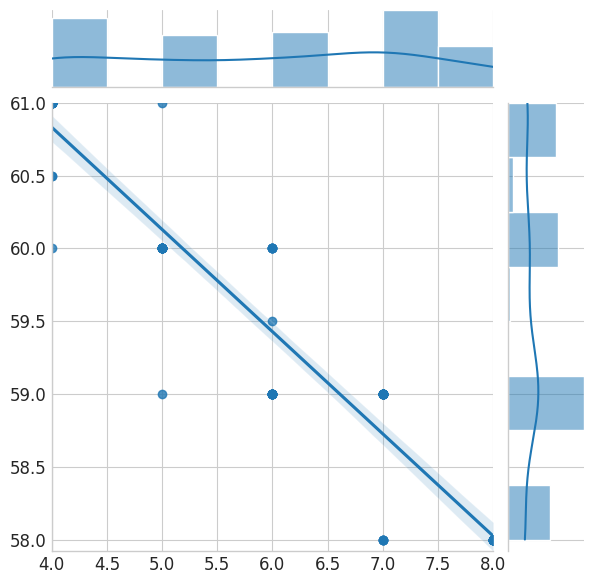

In [ ]:
from scipy.stats import multivariate_normal

# calculate the covariance matrix
data = np.stack((filtered_sleeps['Length (hours)'], filtered_sleeps['Median heart rate']), axis=0)
covariance_matrix = np.cov(data)

# calculating the mean
mean_values = [np.mean(filtered_sleeps['Length (hours)']),np.mean(filtered_sleeps['Median heart rate'])]

# multivariate normal distribution
model = multivariate_normal(cov=covariance_matrix,mean=mean_values)
data = np.stack((filtered_sleeps['Length (hours)'], filtered_sleeps['Median heart rate']),axis=1)

# finding the outliers
# any point with a probability lower than the threshold value is considered an outlier and removed 
threshold = 1.0e-05
outlier = model.pdf(data).reshape(-1) < threshold

new_data = copy.deepcopy(data)

for i, boolean in enumerate(outlier):
  if boolean:
    print(data[i], " is an outlier")
    print(np.where(np.logical_and(data[:,0] == data[i,0], data[:,1] == data[i,1]))[0].item(0))
    # delete outliers
    new_data = np.delete(new_data, np.where(np.logical_and(data[:,0] == data[i,0], data[:,1] == data[i,1]))[0].item(0),axis=0)

# plot new graph with outliers removed
# new_data[:,0] correspond to the new lengths, and new_data[:,1] correspond to the new values
p = sns.jointplot(x=new_data[:,0], y=new_data[:,1], kind='reg')

As we can see, our outlier detection system found the outlier and excluded it from our dataset, as needed.


# 9. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 9.1: Heart rate vs. sleep period length

Maybe the heart rate is correlated with how long a particular sleep period was. Let's see if this hypothesis is true.

Using our previous section's data of median heart rate per sleep session, let's make a quick plot to get some intuition. Here we just use [seaborn](https://seaborn.pydata.org/), as it's very quick to get beautiful plots out with minimal effort. Our first plot is a density plot that shows where the data is most aggregated to emphasize the most common data trends that we may focus our analysis on.

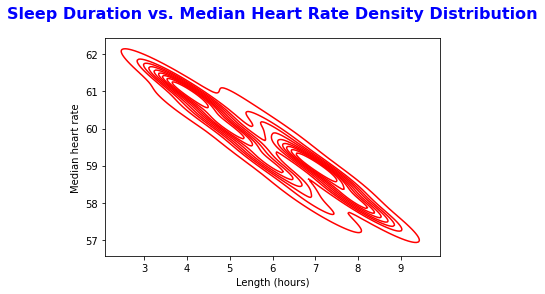

In [ ]:
# Density Plot
sns.kdeplot(x='Length (hours)', y='Median heart rate', data=sleeps_df, color = 'red')

# get the current Axes object
ax = plt.gca()

# set the title of the plot and format it
ax.set_title("Sleep Duration vs. Median Heart Rate Density Distribution", fontsize=16, fontweight="bold", color="blue", pad=20)

# display the plot
plt.show()

Already, we can spot the intuitive trend between sleep duration and median heart rate; longer sleep will result in longer deep sleep phases which is where our heart rate is at its lowest.

Lets dive deeper; now we will plot a scatter plot of all the data points with a line of best fit to solidify our hypothesis. 

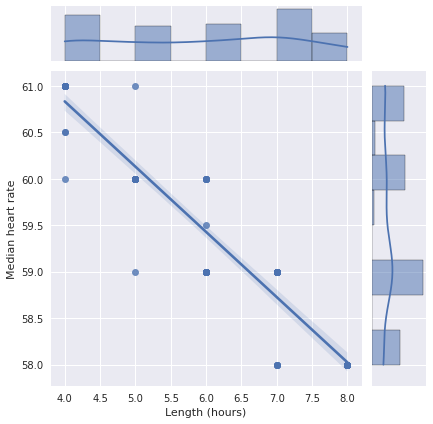

In [ ]:
with plt.style.context('seaborn'):
    p = sns.jointplot(x='Length (hours)', y='Median heart rate', data=sleeps_df, kind='reg')

As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

In [ ]:
from scipy import stats

# eliminate any nan's
filtered_sleeps = sleeps_df[~np.isnan(sleeps_df['Median heart rate'])]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_sleeps['Length (hours)'],
                                                               filtered_sleeps['Median heart rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.702
Coefficient of determination: 0.89
p-value: 4.49e-52


We also see that the p-value, which is determined by scipy to be the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero (our null hypothesis is that sleep duration has no effect on median heart rate), is significant ($<$0.05).

So given this evidence from this particular data, maybe length of a sleep period is correlated with your heart rate.